In [275]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

import joblib

### Анализ данных

In [276]:
train_df = pd.read_parquet("./train.parquet")
train_df.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [277]:
train_df['id'].duplicated().any()

False

In [278]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [279]:
test_df = pd.read_parquet("./test.parquet")
test_df.head()

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."


In [280]:
test_df['id'].duplicated().any()

False

In [281]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  int64 
 1   dates   20000 non-null  object
 2   values  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


In [282]:
train_df.isnull().sum()

id        0
dates     0
values    0
label     0
dtype: int64

In [283]:
test_df.isnull().sum()

id        0
dates     0
values    0
dtype: int64

#### Работа с пропусками

In [284]:
# Пропуски в обуч. выборке
nan_check_train = train_df['values'].apply(lambda x: pd.isnull(x).any())
rows_with_nan_train = train_df[nan_check_train]
rows_with_nan_train

,id,dates,values,label
1979,95215,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0
2328,56091,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0
3244,63162,"[2017-12-01, 2018-01-01, 2018-02-01, 2018-03-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0
3315,29359,"[2016-11-01, 2016-12-01, 2017-01-01, 2017-02-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0
3873,12983,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0
...,...,...,...,...
75207,61409,"[2018-12-01, 2019-01-01, 2019-02-01, 2019-03-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0
75743,28644,"[2019-07-01, 2019-08-01, 2019-09-01, 2019-10-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0
76789,31408,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0
77792,67417,"[2017-04-01, 2017-05-01, 2017-06-01, 2017-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.0


In [285]:
# Удаление пропусков из train
train_df = train_df[~nan_check_train]
train_df.shape

(79912, 4)

In [286]:
# Пропуски в тест. выборке
nan_check_test = test_df['values'].apply(lambda x: pd.isnull(x).any())
rows_with_nan_test = test_df[nan_check_test]
rows_with_nan_test

,id,dates,values
361,5992,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
922,70218,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2193,70630,"[2017-08-01, 2017-09-01, 2017-10-01, 2017-11-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4050,44222,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
6260,85761,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
7822,14263,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
8169,88655,"[2020-04-01, 2020-05-01, 2020-06-01, 2020-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
9731,42125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
10113,93394,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
10891,48564,"[2018-05-01, 2018-06-01, 2018-07-01, 2018-08-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [287]:
# Удаление пропусков из test
test_df = test_df[~nan_check_test]
test_df.shape

(19979, 3)

#### Распределение классов

In [288]:
# Распределение классов
train_df['label'].value_counts()

label
0.0    57785
1.0    22127
Name: count, dtype: int64

#### Типы данных, статистики

In [289]:
train_expanded = pd.DataFrame({
    'id': np.repeat(train_df['id'].values, train_df['dates'].str.len()),
    'label': np.repeat(train_df['label'].values, train_df['dates'].str.len()),
    'date': np.concatenate(train_df['dates'].values),
    'value': np.concatenate(train_df['values'].values)
})

In [290]:
train_expanded

,id,label,date,value
0,19114,0.0,2016-01-01,-1.86000
1,19114,0.0,2016-02-01,0.79000
2,19114,0.0,2016-03-01,1.40000
3,19114,0.0,2016-04-01,0.15000
4,19114,0.0,2016-05-01,0.00000
...,...,...,...,...
5150825,98870,1.0,2019-11-01,1.40335
5150826,98870,1.0,2019-12-01,0.26335
5150827,98870,1.0,2020-01-01,-1.73665
5150828,98870,1.0,2020-02-01,-0.38665


In [291]:
train_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150830 entries, 0 to 5150829
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   label   float64
 2   date    object 
 3   value   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 157.2+ MB


In [292]:
train_expanded.groupby('label')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0.0,3741768.0,0.000550,1.218057,-7.48,-0.81,-0.09,0.79,9.27
1.0,1409062.0,-0.110514,1.238861,-7.95,-0.91,-0.20,0.68,9.54


#### Визуализация рядов

In [293]:
class_0 = train_df[train_df['label'] == 0]
class_1 = train_df[train_df['label'] == 1]

In [294]:
class_0.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
5,59504,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[0.08, 0.88, 1.46, 0.59, -0.97, -0.41, 0.78, -...",0.0


In [295]:
class_1.head()

,id,dates,values,label
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
8,87449,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.92, 4.11, 3.39, -1.17, -0.79, 2.15, -0.22, ...",1.0
9,43415,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-0.86, -0.05, -0.35, -0.67, -0.25, -0.8, -0.6...",1.0
18,94983,"[2019-11-01, 2019-12-01, 2020-01-01, 2020-02-0...","[0.92, 0.11, -0.16, 0.78, -0.49, 1.13, -0.55, ...",1.0
20,62582,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[1.04, 0.44, 1.24, -1.1, 1.43, -0.53, -0.45, 0...",1.0


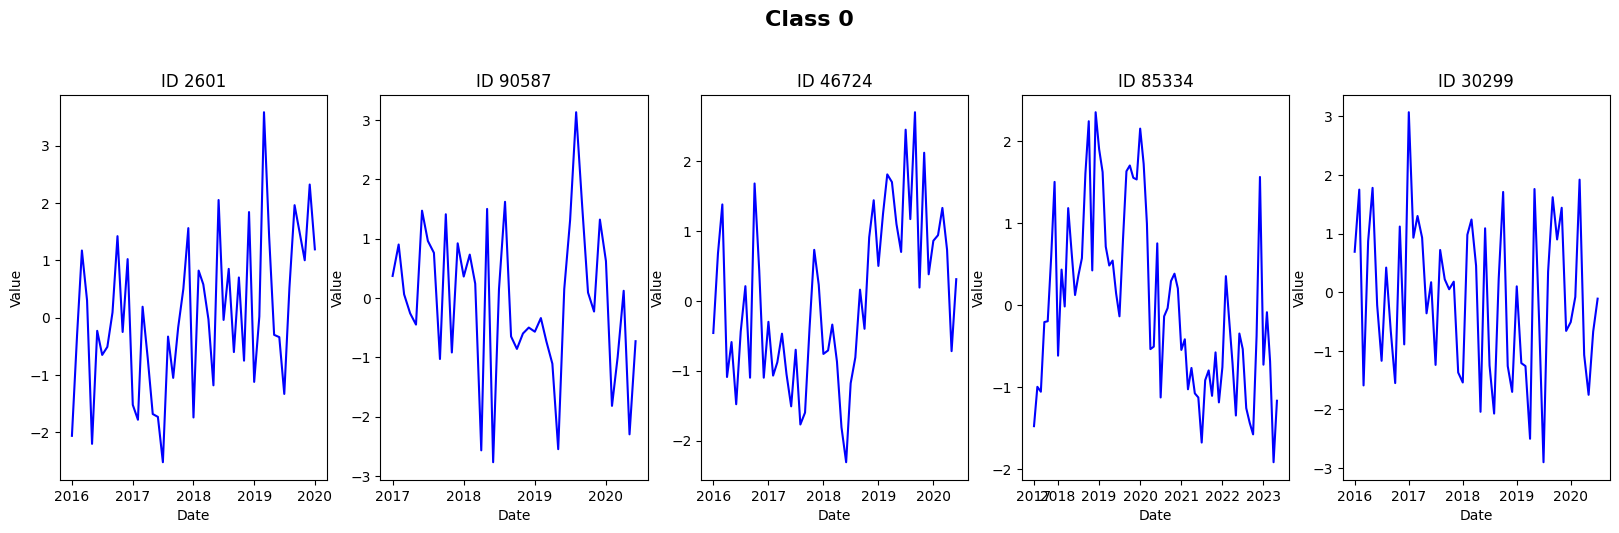

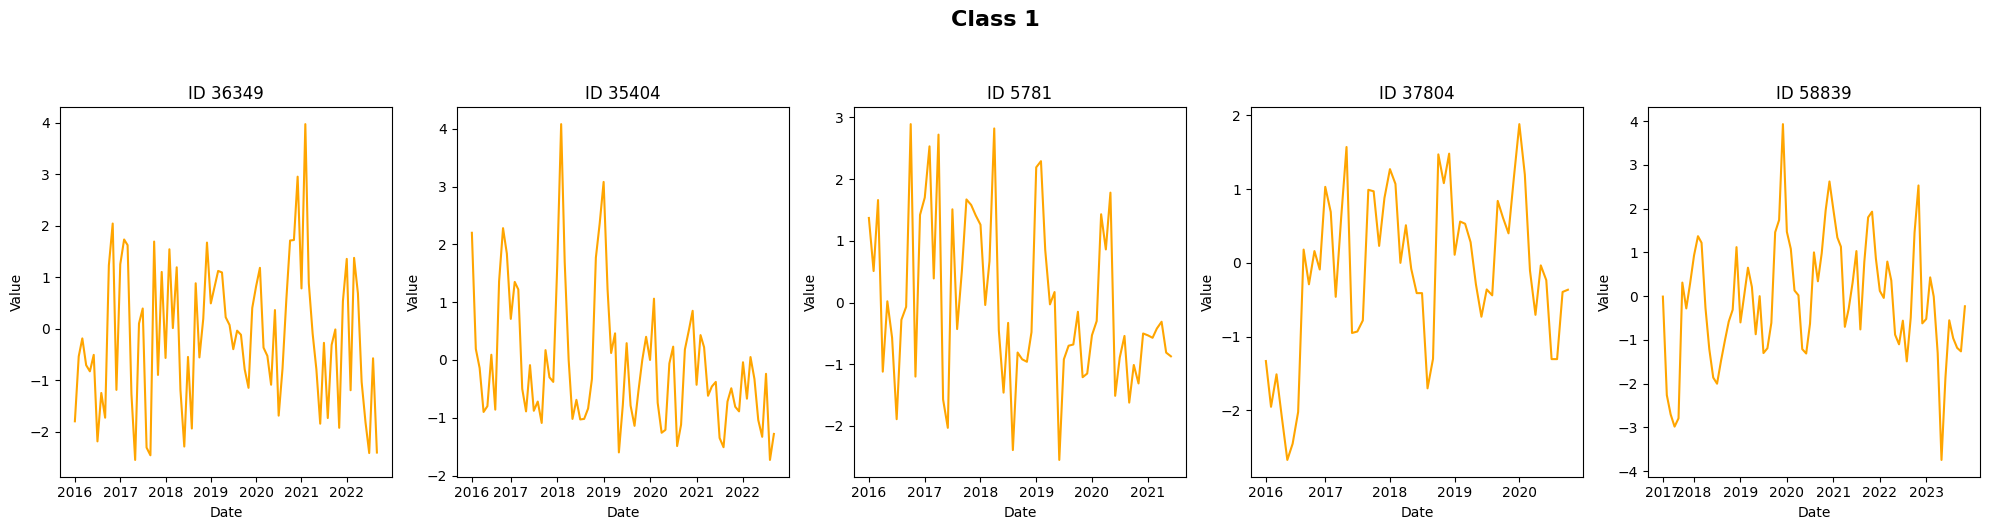

In [296]:
sample_0 = class_0.sample(n=5, random_state=42)
sample_1 = class_1.sample(n=5, random_state=42)

fig1, axes1 = plt.subplots(1, 5, figsize=(20, 5))
fig2, axes2 = plt.subplots(1, 5, figsize=(20, 5))

for i, row in enumerate(sample_0.iterrows()):
    idx, data = row
    ax = axes1[i]
    ax.plot(data['dates'], data['values'], color='blue')
    ax.set_title(f'ID {data["id"]}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    
    years = pd.DatetimeIndex(data['dates']).year
    unique_years = np.unique(years)
    year_dates = [data['dates'][years == year][0] for year in unique_years]
    ax.set_xticks(year_dates)
    ax.set_xticklabels(unique_years)

for i, row in enumerate(sample_1.iterrows()):
    idx, data = row
    ax = axes2[i]
    ax.plot(data['dates'], data['values'], color='orange')
    ax.set_title(f'ID {data["id"]}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    
    years = pd.DatetimeIndex(data['dates']).year
    unique_years = np.unique(years)
    year_dates = [data['dates'][years == year][0] for year in unique_years]
    ax.set_xticks(year_dates)
    ax.set_xticklabels(unique_years)

fig1.suptitle('Class 0', fontsize=16, fontweight='bold', y=1.05)
fig2.suptitle('Class 1', fontsize=16, fontweight='bold', y=1.05)

plt.tight_layout()

plt.show()

#### Сезонность, тренд

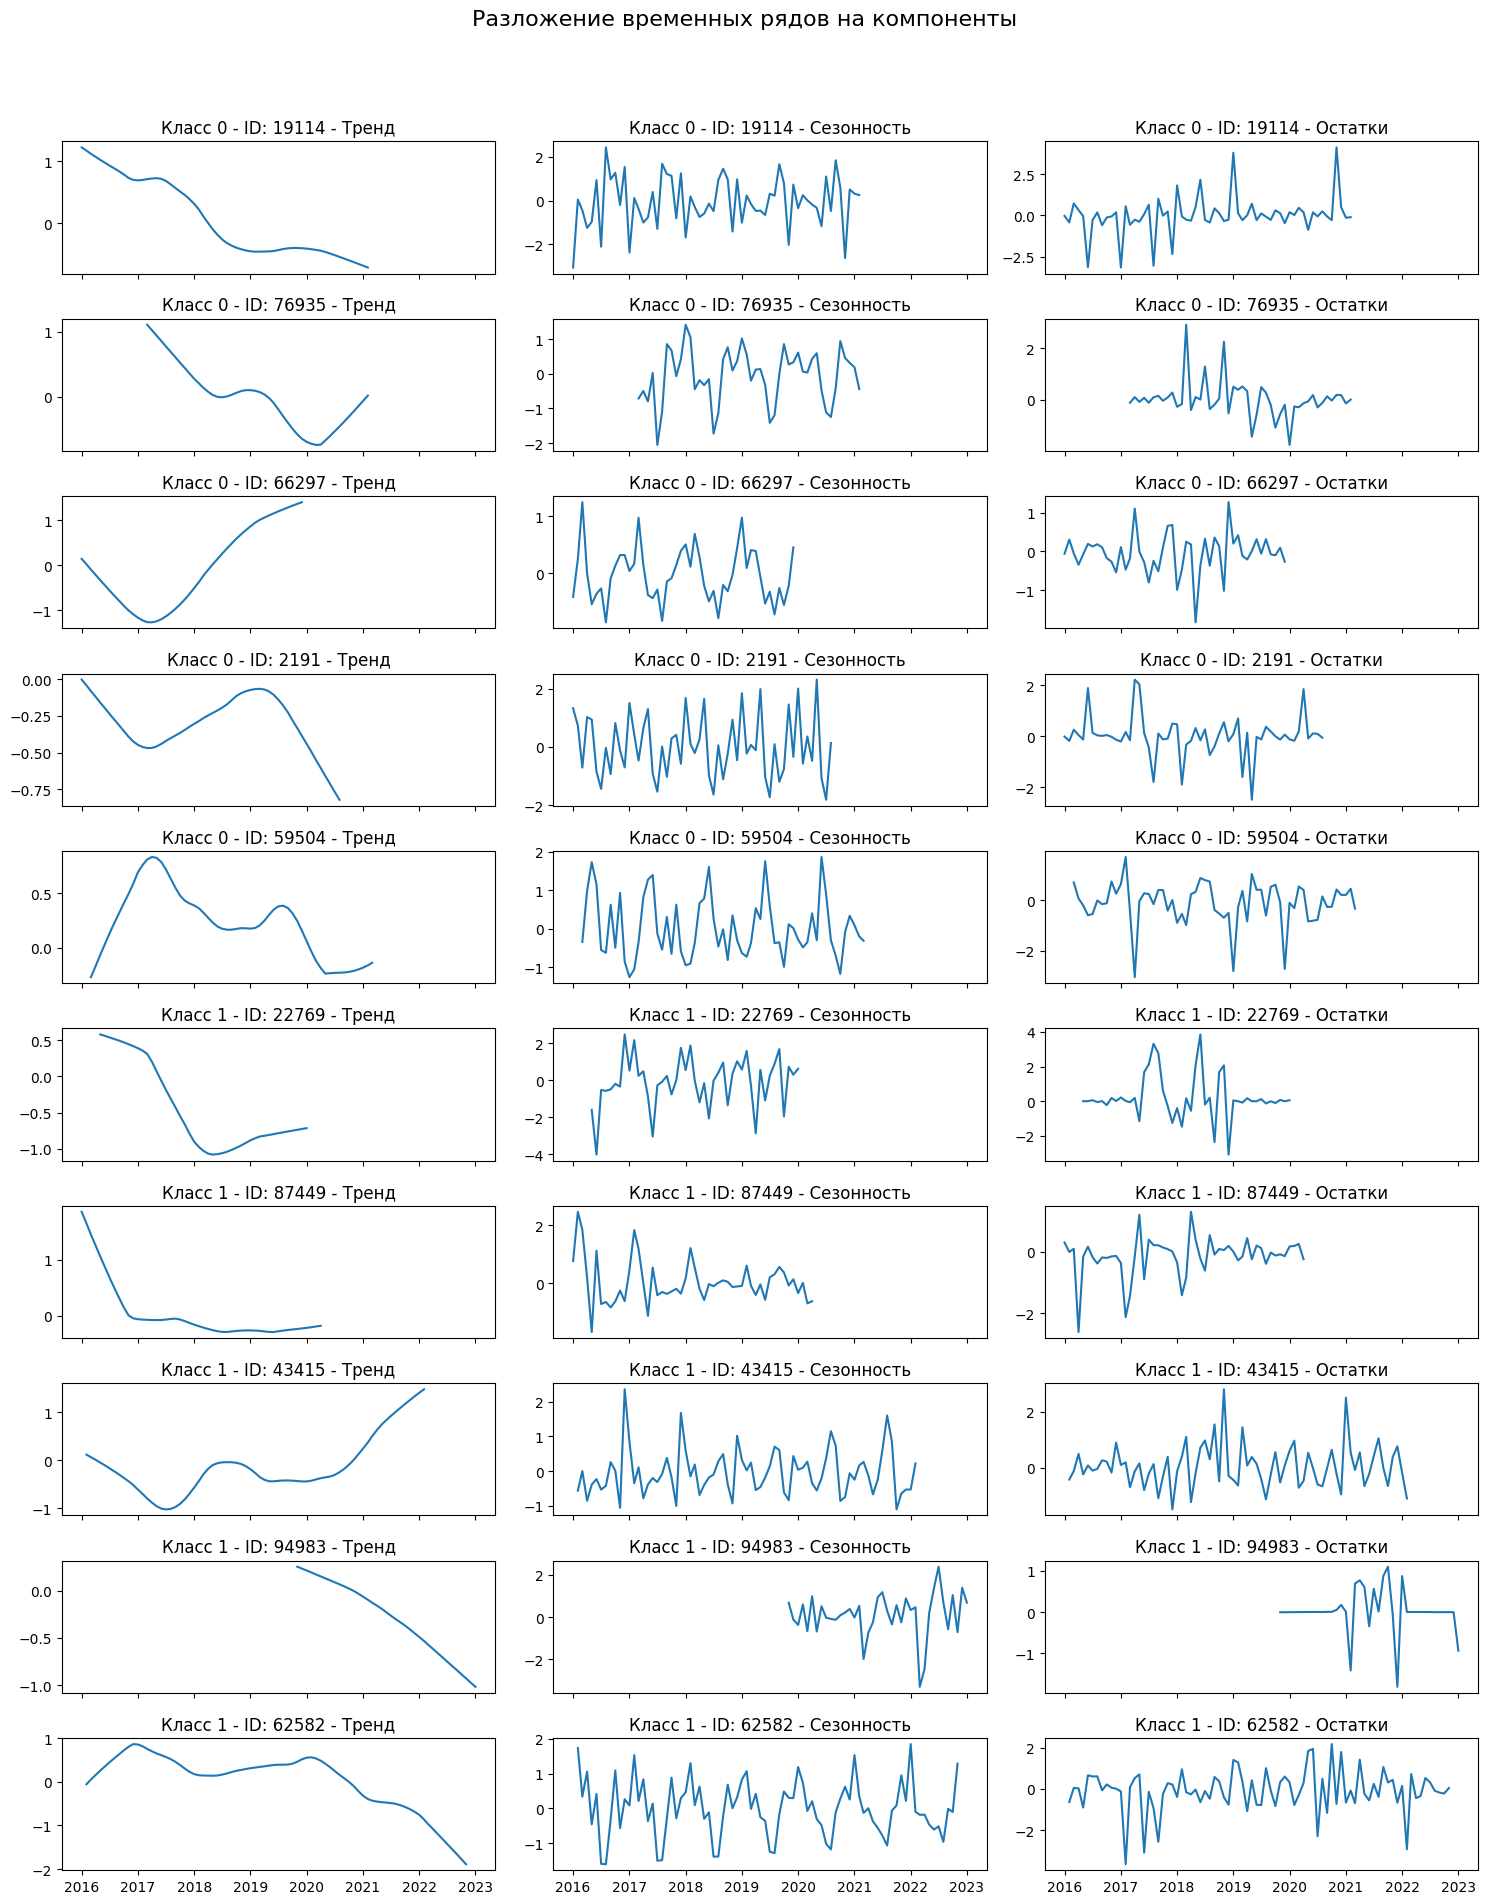

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

train_expanded['date'] = pd.to_datetime(train_expanded['date'])

def decompose_time_series(series, frequency=13):
    stl = STL(series, seasonal=frequency, robust=True)
    result = stl.fit()
    return result

n_objects = 5

class_0_ids = train_expanded[train_expanded['label'] == 0]['id'].unique()[:n_objects]
class_1_ids = train_expanded[train_expanded['label'] == 1]['id'].unique()[:n_objects]

# Подготовим фигуру для визуализации
fig, axes = plt.subplots(n_objects * 2, 3, figsize=(15, n_objects * 4), sharex=True)

for i, obj_id in enumerate(class_0_ids):
    series = train_expanded[train_expanded['id'] == obj_id].set_index('date')['value']
    decomposition = decompose_time_series(series)
    
    # Визуализация разложения
    # Тренд
    axes[i, 0].plot(decomposition.trend)
    axes[i, 0].set_title(f'Класс 0 - ID: {obj_id} - Тренд')
    
    # Сезонность
    axes[i, 1].plot(decomposition.seasonal)
    axes[i, 1].set_title(f'Класс 0 - ID: {obj_id} - Сезонность')
    
    # Остатки
    axes[i, 2].plot(decomposition.resid)
    axes[i, 2].set_title(f'Класс 0 - ID: {obj_id} - Остатки')

for i, obj_id in enumerate(class_1_ids):
    series = train_expanded[train_expanded['id'] == obj_id].set_index('date')['value']
    decomposition = decompose_time_series(series)
    
    
    # Тренд
    axes[i + n_objects, 0].plot(decomposition.trend)
    axes[i + n_objects, 0].set_title(f'Класс 1 - ID: {obj_id} - Тренд')
    
    # Сезонность
    axes[i + n_objects, 1].plot(decomposition.seasonal)
    axes[i + n_objects, 1].set_title(f'Класс 1 - ID: {obj_id} - Сезонность')
    
    # Остатки
    axes[i + n_objects, 2].plot(decomposition.resid)
    axes[i + n_objects, 2].set_title(f'Класс 1 - ID: {obj_id} - Остатки')

plt.suptitle('Разложение временных рядов на компоненты', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Проверка гипотез

In [298]:
class_0_array = np.concatenate(train_df[train_df['label'] == 0]['values'].values)
class_1_array = np.concatenate(train_df[train_df['label'] == 1]['values'].values)

In [299]:
# Гипотеза 1: Проверка различия средних значений (t-тест)
t_stat, p_value = stats.ttest_ind(class_0_array, class_1_array)
alpha = 0.05
print(f"T-тест: T-статистика = {t_stat}, p-значение = {p_value}")
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: есть значимая разница в средних значениях.")
else:
    print("Не можем отвергнуть нулевую гипотезу: нет значимой разницы в средних значениях.")

T-тест: T-статистика = 91.81913242542578, p-значение = 0.0
Отвергаем нулевую гипотезу: есть значимая разница в средних значениях.


In [300]:
# Гипотеза 2: Проверка различия дисперсий (F-тест)
f_stat, p_value_f = stats.levene(class_0_array, class_1_array)
print(f"F-тест: F-статистика = {f_stat}, p-значение = {p_value_f}")
if p_value_f < alpha:
    print("Отвергаем нулевую гипотезу: есть значимая разница в дисперсии.")
else:
    print("Не можем отвергнуть нулевую гипотезу: нет значимой разницы в дисперсии.")

F-тест: F-статистика = 36.97267684948055, p-значение = 1.1980464615789573e-09
Отвергаем нулевую гипотезу: есть значимая разница в дисперсии.


### Создание признаков

In [301]:
def extract_features(row):
    values = row['values']
    dates = row['dates']
    
    fft_values = np.fft.fft(values)
    
    feat_dict = {
        'mean': np.mean(values),
        'std': np.std(values),
        'min': np.min(values),
        'max': np.max(values),
        'median': np.median(values),
        'skew': pd.Series(values).skew(),
        'kurtosis': pd.Series(values).kurtosis(),
        'diff_mean': np.mean(np.diff(values)),
        'diff_std': np.std(np.diff(values)),
        'q25': np.percentile(values, 25),
        'q75': np.percentile(values, 75),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'autocorr_1': pd.Series(values).autocorr(lag=1),
        'autocorr_7': pd.Series(values).autocorr(lag=7),
        'trend': np.polyfit(np.arange(len(values)), values, 1)[0],
        'seasonal_strength': np.std(np.diff(values, 7)) / np.std(np.diff(values)) if len(values) > 7 else 0,
        'peak_count': ((np.diff(np.sign(np.diff(values))) > 0).sum() + 1),
    }
    
    return feat_dict

In [302]:
train_features = train_df.apply(extract_features, axis=1)
train_features_df = pd.DataFrame(features.tolist())

In [303]:
train_features_df

,mean,std,min,max,median,skew,kurtosis,diff_mean,diff_std,q25,q75,iqr,autocorr_1,autocorr_7,trend,seasonal_strength,peak_count
0,0.023710,1.337272,-4.840000,3.49,-0.110000,-0.311759,2.154785,0.021148,1.993975,-0.682500,0.7700,1.452500,-0.113649,0.156367,-0.011222,44.131957,19
1,-0.310777,1.556337,-3.534409,2.92,-0.274409,-0.012368,0.025976,0.022400,2.000644,-1.040000,0.7100,1.750000,0.189858,-0.001502,-0.026755,36.821261,16
2,-0.046042,1.065023,-1.950000,2.61,-0.145000,0.389424,-0.167206,-0.014894,1.073534,-0.877500,0.6150,1.492500,0.501409,0.002904,-0.032482,39.960754,15
3,-0.130000,1.158201,-2.220000,2.49,-0.345000,0.116053,-0.809032,0.040851,0.888266,-0.950000,0.8250,1.775000,0.705215,0.329671,0.049298,27.529897,12
4,-0.270536,1.270529,-2.500000,2.87,-0.475000,0.409712,-0.527906,-0.037455,1.717244,-1.250000,0.6775,1.927500,0.088913,-0.043737,-0.011478,38.581498,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79907,0.163818,1.303965,-3.640000,2.56,0.160000,-0.737560,1.193993,0.043148,1.691542,-0.360000,1.0150,1.375000,0.154770,-0.133654,-0.005509,34.735923,18
79908,-0.112555,1.216413,-2.590000,2.16,-0.180000,0.114586,-1.044084,0.003455,1.313139,-1.120319,1.1200,2.240319,0.428092,-0.461770,-0.012999,39.582346,17
79909,-0.201373,1.182551,-2.890000,2.27,-0.140000,-0.057328,-0.137552,-0.042200,1.372824,-0.905000,0.4950,1.400000,0.302005,0.300635,0.039878,41.185150,18
79910,-0.075397,1.491254,-2.850000,3.11,0.240000,-0.146265,-0.959543,0.047742,1.605315,-1.465000,0.9850,2.450000,0.418320,-0.264983,0.006774,40.225670,21


In [304]:
test_features = test_df.apply(extract_features, axis=1)
test_features_df = pd.DataFrame(test_features.tolist())

In [305]:
test_features_df

,mean,std,min,max,median,skew,kurtosis,diff_mean,diff_std,q25,q75,iqr,autocorr_1,autocorr_7,trend,seasonal_strength,peak_count
0,0.037895,1.505985,-3.140000,3.13,-0.010,0.067832,-0.342699,-0.037857,1.705358,-0.950000,1.0100,1.960000,0.361637,-0.383440,-0.010018,42.497611,18
1,-0.016909,1.249663,-2.240000,3.85,-0.080,0.899283,1.058050,0.051667,1.740456,-0.950000,0.5150,1.465000,0.013262,-0.022973,-0.009304,45.612148,20
2,-0.039569,1.000514,-1.450000,3.46,-0.160,0.991187,1.296155,0.031071,1.116893,-0.785000,0.5400,1.325000,0.376190,-0.014410,0.025446,44.960813,18
3,0.159231,1.313112,-2.730000,3.43,0.110,0.392145,0.022481,0.010260,1.597142,-0.710000,0.7200,1.430000,0.260440,-0.039477,-0.008521,37.704637,27
4,-0.094705,1.243279,-2.660000,2.57,-0.090,-0.033056,-0.479235,-0.059802,1.391119,-1.030000,0.9100,1.940000,0.358273,0.064295,-0.024730,37.573505,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,-0.022217,1.077283,-1.550000,3.86,-0.275,1.539639,2.963392,-0.043131,1.198417,-0.767500,0.4550,1.222500,0.357038,0.223554,-0.004308,34.657744,27
19975,0.072439,1.381959,-3.000000,2.78,0.260,-0.281797,-0.602788,0.010988,1.297124,-1.010000,1.2600,2.270000,0.561300,-0.506351,0.002278,27.795181,20
19976,0.068727,1.173802,-3.660000,1.91,0.290,-1.273287,1.753140,0.030370,0.749639,-0.235000,0.7700,1.005000,0.796134,0.034943,0.002200,29.768585,16
19977,-0.037175,1.177763,-2.801675,2.40,-0.180,0.122512,-0.574782,-0.068482,1.389823,-0.958756,0.9375,1.896256,0.274404,0.397170,-0.061743,42.208894,15


### Обучение модели

In [306]:
y = train_df['label']

In [307]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [308]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt', 
    'num_leaves': 31,          
    'learning_rate': 0.05,    
    'n_estimators': 300,       
    'class_weight': 'balanced',  
}

model = lgb.LGBMClassifier(**params)

In [309]:
roc_auc_scores = cross_val_score(model, train_features_df, y, cv=skf, scoring='roc_auc')

[LightGBM] [Info] Number of positive: 17701, number of negative: 46228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4118
[LightGBM] [Info] Number of data points in the train set: 63929, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 17701, number of negative: 46228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4118
[LightGBM] [Info] Number of data points in the train set: 63929, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[Ligh

In [310]:
print("Средний ROC AUC:", roc_auc_scores.mean())

Средний ROC AUC: 0.8888365127168406


In [311]:
model.fit(train_features_df, y)

[LightGBM] [Info] Number of positive: 22127, number of negative: 57785
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4118
[LightGBM] [Info] Number of data points in the train set: 79912, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.05, metric='auc',
               n_estimators=300, objective='binary')

### Сохранение модели

In [312]:
joblib.dump(model, 'model.joblib')

['model.joblib']

In [313]:
joblib.dump(test_features_df, 'test_features.joblib')

['test_features.joblib']